<a href="https://colab.research.google.com/github/azh248/galaxy-mergers-desi/blob/main/zoobot_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import logging
import os
import sys

import numpy as np
import pandas as pd

logging.basicConfig(level=logging.INFO)

In [2]:
import torch
torch.__version__

'2.5.1+cu121'

This notebook demonstrates finetuning Zoobot.

Finetuning means adapting a model pretrained on a large amount of data (here, many Galaxy Zoo answers) to solve a new problem using a small amount of new data.

We follow these steps:
- Install Zoobot (PyTorch version)
- Download the data to finetune on, starting from that checkpoint and the data to finetune on (ring images and ring label catalog)
- Download a pretrained checkpoint from HuggingFace
- Configure and run the finetuning

For standalone script examples, see zoobot/pytorch/examples/finetuning



---



*Retraining will be quite slow unless you use a GPU. Use the top
toolbar: Runtime- > Change Runtime -> GPU*

---

## Install Zoobot

In [3]:
!pip install zoobot[pytorch-colab] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.5/120.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 36.8 MB/s eta 0:00:00




If you will get the error below later:
> AttributeError: module 'pkg_resources._vendor.packaging' has no attribute 'requirements'

then restart the runtime and run it again - press the button just above.

In [4]:
# colab is weird sometimes and erratically needs this hack to make imports work
# no need to do this locally
sys.path.append('/content/galaxy-datasets')
sys.path.append('/content/zoobot')
sys.path.append('/content/zoobot/pytorch')


Now we're set up and can start using Zoobot.

## Download Catalogs of Images and Labels

Each catalog should be a dataframe with columns of "id_str", "file_loc", and any labels.

Here I'm using galaxy-datasets to download some premade data - check it out for examples.

In [5]:


# galaxy-datasets is a dependency of Zoobot.
# It has code handling downloading and loading data.
from galaxy_datasets import gz_candels

data_dir = '/content/gz_candels'

train_catalog_raw, _ = gz_candels(root=data_dir, download=True, train=True)
test_catalog_raw, _ = gz_candels(root=data_dir, download=True, train=False)
train_catalog = pd.DataFrame()
test_catalog = pd.DataFrame()

100%|██████████| 4177120/4177120 [00:00<00:00, 84443630.50it/s]


100%|██████████| 1162980/1162980 [00:00<00:00, 30181051.14it/s]


100%|██████████| 6446950787/6446950787 [01:21<00:00, 78663573.51it/s]


Extracting /content/gz_candels/candels_images.tar.gz to /content/gz_candels


In [6]:
# # FOR DEBUGGING PURPOSES ONLY

# train_catalog = pd.DataFrame()
# test_catalog = pd.DataFrame()

# print(len(train_catalog_raw))
# print(len(test_catalog_raw))

# print(len(train_catalog_raw.index))
# print(len(test_catalog_raw.index))

In [7]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 32.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [8]:
# calculate fraction of respondents who voted that the picture was of a merger
total_mergers = train_catalog_raw['merging-candels_merger'] + train_catalog_raw['merging-candels_both']
total_responses = total_mergers + train_catalog_raw['merging-candels_neither'] + train_catalog_raw['merging-candels_tidal-debris']
train_catalog_raw['merger_frac'] = total_mergers / total_responses
total_mergers = test_catalog_raw['merging-candels_merger'] + test_catalog_raw['merging-candels_both']
total_responses = total_mergers + test_catalog_raw['merging-candels_neither'] + test_catalog_raw['merging-candels_tidal-debris']
test_catalog_raw['merger_frac'] = total_mergers / total_responses

label_cols = ['merger']  # will use later

# convert fraction of merger votes to a binary yes/no classification
mergeCol = train_catalog_raw['merger_frac']
train_catalog_raw = train_catalog_raw.loc[(mergeCol > 0.8) | (mergeCol < 0.2)]
train_catalog_raw['merger'] = train_catalog_raw['merger_frac'] > 0.8
train_catalog_raw.head()

mergeCol = test_catalog_raw['merger_frac']
test_catalog_raw = test_catalog_raw.loc[(mergeCol > 0.8) | (mergeCol < 0.2)]
test_catalog_raw['merger'] = test_catalog_raw['merger_frac'] > 0.8
test_catalog_raw.head()

# balance dataset
train_mergers = train_catalog_raw.loc[train_catalog_raw['merger'] == 1]
train_non_mergers = train_catalog_raw.loc[train_catalog_raw['merger'] == 0]
train_balanced_non_mergers = train_non_mergers.head(len(train_mergers))
train_catalog = pd.concat([train_mergers, train_balanced_non_mergers])

test_mergers = test_catalog_raw.loc[test_catalog_raw['merger'] == 1]
test_non_mergers = test_catalog_raw.loc[test_catalog_raw['merger'] == 0]
test_balanced_non_mergers = test_non_mergers.head(len(test_mergers))
test_catalog = pd.concat([test_mergers, test_balanced_non_mergers])

# reset indexes of dataframe (otherwise they will retain original indexes from before slicing)
train_catalog.reset_index(drop=True,inplace=True)
test_catalog.reset_index(drop=True,inplace=True)

<ipython-input-8-f8f2985e3a68>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_catalog_raw['merger'] = train_catalog_raw['merger_frac'] > 0.8
<ipython-input-8-f8f2985e3a68>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_catalog_raw['merger'] = test_catalog_raw['merger_frac'] > 0.8


In [9]:
# train_catalog['file_loc'] = train_catalog_raw['file_loc']
# test_catalog['file_loc'] = test_catalog_raw['file_loc']
train_catalog['id_str'] = train_catalog['filename']
test_catalog['id_str'] = test_catalog['filename']
# train_catalog['filename'] = train_catalog_raw['filename']
# test_catalog['filename'] = test_catalog_raw['filename']

train_catalog.head()
test_catalog.head()

# print(len(train_catalog_raw.index))
# print(len(train_catalog_raw.columns))
# print(len(train_catalog.index))
# print(len(train_catalog.columns))

,smooth-or-featured-candels_smooth,smooth-or-featured-candels_features,smooth-or-featured-candels_artifact,how-rounded-candels_completely,how-rounded-candels_in-between,how-rounded-candels_cigar-shaped,clumpy-appearance-candels_yes,clumpy-appearance-candels_no,clump-count-candels_1,clump-count-candels_2,...,merging-candels_tidal-debris,merging-candels_both,merging-candels_neither,filename,ra,dec,file_loc,merger_frac,merger,id_str
0,27.0,25.0,22.0,18.0,9.0,0.0,22.0,3.0,0.0,22.0,...,0.0,2.0,7.0,GDS_2428.jpg,53.116118,-27.893268,/content/gz_candels/images/GDS_2428.jpg,0.865385,True,GDS_2428.jpg
1,35.0,21.0,19.0,0.0,16.0,19.0,7.0,14.0,0.0,7.0,...,0.0,7.0,9.0,COS_27140.jpg,150.175380,2.524987,/content/gz_candels/images/COS_27140.jpg,0.839286,True,COS_27140.jpg
2,38.0,21.0,17.0,19.0,18.0,1.0,16.0,5.0,0.0,11.0,...,1.0,5.0,7.0,GDS_14580.jpg,53.126990,-27.779735,/content/gz_candels/images/GDS_14580.jpg,0.864407,True,GDS_14580.jpg
3,39.0,9.0,24.0,3.0,34.0,2.0,5.0,4.0,2.0,3.0,...,1.0,3.0,8.0,GDS_6668.jpg,53.126628,-27.848169,/content/gz_candels/images/GDS_6668.jpg,0.812500,True,GDS_6668.jpg
4,9.0,8.0,6.0,3.0,6.0,0.0,6.0,2.0,0.0,3.0,...,0.0,8.0,3.0,GDS_21383.jpg,53.124456,-27.719193,/content/gz_candels/images/GDS_21383.jpg,0.823529,True,GDS_21383.jpg


In [69]:
import albumentations as A
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1,brightness_limit=(0,0.4),
                               contrast_limit=(0,1)),
    A.VerticalFlip(p=1),
    A.AdvancedBlur(blur_limit=11,p=1),
    A.Sharpen(p=1),
    A.PlasmaShadow(p=1),
    A.PlanckianJitter(p=1),
    A.FancyPCA(p=1),
    A.Illumination(p=1),
    A.Emboss(p=1),
    A.MotionBlur(p=1),
    A.ColorJitter(brightness=(0.4,0.6),hue=0,p=1),
    A.RGBShift(r_shift_limit=(0, 20), g_shift_limit=(0, 20),
               b_shift_limit=(0, 20)),
    A.ToGray(p=1),
    A.InvertImg(p=1)
])

newpath = '/content/gz_candels/images_transformed'
if not os.path.exists(newpath):
  os.mkdir(newpath)

for n in range(len(train_catalog.index)):
  file_loc = train_catalog.iloc[n]['file_loc']
  # print(file_loc)
  im = Image.open(file_loc)
  transformed_im_dict = transform(image=np.array(im))
  transformed_im = Image.fromarray(transformed_im_dict['image'])
  # print(type(transformed_im))
  # plt.imshow(im)
  # plt.show()
  # plt.imshow(transformed_im)
  # plt.show()
  new_file_loc = '/content/gz_candels/images_transformed/' + train_catalog.iloc[n]['filename']
  transformed_im.save(new_file_loc)
  train_catalog.at[n,'file_loc'] = new_file_loc

for n in range(len(test_catalog.index)):
  file_loc = test_catalog.iloc[n]['file_loc']
  im = Image.open(file_loc)
  transformed_im_dict = transform(image=np.array(im))
  transformed_im = Image.fromarray(transformed_im_dict['image'])
  # print(type(transformed_im))
  # plt.imshow(im)
  # plt.show()
  # plt.imshow(transformed_im)
  # plt.show()
  # break
  new_file_loc = '/content/gz_candels/images_transformed/' + test_catalog.iloc[n]['filename']
  transformed_im.save(new_file_loc)
  test_catalog.at[n,'file_loc'] = new_file_loc

The catalog must have:
- Column(s) with your labels e.g. `ring`.
- `id_str` to identify each row. Can be anything unique.
- `file_loc` column with paths to each image (.jpg, .png and .fits are supported - see the docs)


For multiple classes, use multiple columns with one-hot labels. For example:

In [70]:
# example_multiclass_labels = pd.DataFrame([[0,1,0],[1,0,0],[0, 0,1]], columns=['class_a', 'class_b', 'class_c'])
# example_multiclass_labels # just to illustrate. not used here as we're doing binary classification.

For binary classification, a single column with boolean or integer labels is enough. We'll define `label_cols=["ring"]` below and pass it to our dataloader later.



Why a list? To support more complicated labels, Zoobot expects a list of columns. A list with one element works fine for classification.

Optional: check `id_str` is unique. No galaxy should appear twice.

In [71]:
all_id_strs = list(train_catalog['filename']) + list(test_catalog['filename'])
assert pd.value_counts(all_id_strs).max() == 1

<ipython-input-71-84ebfc147caf>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  assert pd.value_counts(all_id_strs).max() == 1
<ipython-input-71-84ebfc147caf>:2: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  assert pd.value_counts(all_id_strs).max() == 1


Optional: check that all images load correctly.

Worth checking once, and especially if you get "InvalidArgumentError" when running the model below.

In [72]:
assert all([os.path.isfile(loc) for loc in train_catalog['file_loc']])

In [73]:
from galaxy_datasets.pytorch.galaxy_datamodule import GalaxyDataModule

datamodule = GalaxyDataModule(
  label_cols=label_cols,  # specifying which columns to load as labels with `label_cols`
  catalog=train_catalog,
  batch_size=32,
  resize_after_crop=224,  # the size of the images input to the model
  num_workers=2,  # sets the parallelism for loading data. 2 works well on colab.
  greyscale=False  # Most Zoobot checkpoints expect color images
)

In [74]:
# just to demonstrate what datamodule returns. you don't need to do this.
datamodule.setup()
for batch in datamodule.train_dataloader():
  images = batch[0]
  labels = batch[1]
  print(images.min(), images.max(), images.shape)
  print(labels)
  break

tensor(0.) tensor(0.9961) torch.Size([32, 3, 224, 224])
tensor([1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.])


## Download Pretrained Model

Download the pretrained model checkpoint from HuggingFace.

Many popular architectures are available. See the collection [here](https://huggingface.co/collections/mwalmsley/zoobot-encoders-65fa14ae92911b173712b874) and the Zoobot [docs](https://zoobot.readthedocs.io/en/latest/data_notes.html). I suggest starting with ConvNeXT-Nano, which is small yet high-performing.



In [75]:
from zoobot.pytorch.training.finetune import FinetuneableZoobotClassifier

model = FinetuneableZoobotClassifier(

    # arguments for any FinetuneableZoobot class
    # there are many options for customizing finetuning. See the FinetuneableZoobotAbstract docstring.
    name='hf_hub:mwalmsley/zoobot-encoder-convnext_pico',
    n_blocks=5,  # Finetune this many blocks. Set 0 for only the head. Set e.g. 1, 2 to finetune deeper (5 max for convnext).
    learning_rate=1e-5,  # use a low learning rate
    lr_decay=0.5,  # reduce the learning rate from lr to lr^0.5 for each block deeper in the network

    # arguments specific to FinetuneableZoobotClassifier
    num_classes=2
)

# Now the Actual Finetuning

In [76]:
from zoobot.pytorch.training.finetune import get_trainer

# TODO you can update these paths to suit own data
save_dir = os.path.join('/content/zoobot/results/pytorch/finetune/finetune_binary_classification')

trainer = get_trainer(save_dir, accelerator='auto', devices='auto', max_epochs=5)
trainer.fit(model, datamodule)
# should reach about 85% accuracy, loss of about 0.40

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type           | Params | Mode 
-------------------------------------------------------------
0 | encoder           | ConvNeXt       | 8.5 M  | train
1 | train_loss_metric | MeanMetric     | 0      | train
2 | val_loss_metric   | MeanMetric     | 0      | train
3 | test_loss_metric  | MeanMetric     | 0      | train
4 | head              | LinearHead     | 1.0 K  | train
5 |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (19) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 19: 'finetuning/val_loss' reached 0.71444 (best 0.71444), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/0-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 38: 'finetuning/val_loss' reached 0.68339 (best 0.68339), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 57: 'finetuning/val_loss' reached 0.67040 (best 0.67040), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/2.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 76: 'finetuning/val_loss' reached 0.66427 (best 0.66427), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 95: 'finetuning/val_loss' reached 0.65950 (best 0.65950), saving model to '/content/zoobot/results/pytorch/finetune/finetune_binary_classification/checkpoints/4-v1.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [77]:
# now we can load the best checkpoint and make predictions
best_checkpoint = trainer.checkpoint_callback.best_model_path
finetuned_model = FinetuneableZoobotClassifier.load_from_checkpoint(best_checkpoint)

In [78]:
from zoobot.pytorch.predictions import predict_on_catalog

_ = predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=1,
  # CAREFUL! For classification, we unpack a single column like [1, 0, 1, 2, ...] into N classes automatically
  # but when making predictions, we make a prediction per class, so (unlike for training) this prediction `label_cols` needs n_classes entries
  # e.g. [class_for_label_0, class_for_label_1, ...
  label_cols=['not_merger', 'merger'],  # name the output columns
  save_loc=os.path.join(save_dir, 'finetuned_predictions.csv'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Let's quickly check if they're any good:

In [79]:
predictions = pd.read_csv(os.path.join(save_dir, 'finetuned_predictions.csv'))
predictions.head()

,id_str,not_merger_pred,merger_pred
0,GDS_2428.jpg,0.478111,0.521889
1,COS_27140.jpg,0.469841,0.530159
2,GDS_14580.jpg,0.409658,0.590342
3,GDS_6668.jpg,0.491574,0.508426
4,GDS_21383.jpg,0.463270,0.536730


In [80]:
predictions = pd.merge(predictions, test_catalog[['id_str', 'file_loc', 'merger']])
predictions.head()

,id_str,not_merger_pred,merger_pred,file_loc,merger
0,GDS_2428.jpg,0.478111,0.521889,/content/gz_candels/images_transformed/GDS_242...,True
1,COS_27140.jpg,0.469841,0.530159,/content/gz_candels/images_transformed/COS_271...,True
2,GDS_14580.jpg,0.409658,0.590342,/content/gz_candels/images_transformed/GDS_145...,True
3,GDS_6668.jpg,0.491574,0.508426,/content/gz_candels/images_transformed/GDS_666...,True
4,GDS_21383.jpg,0.463270,0.536730,/content/gz_candels/images_transformed/GDS_213...,True


Accuracy: 0.768
0      0.521889
1      0.530159
2      0.590342
3      0.508426
4      0.536730
         ...   
245    0.405966
246    0.468273
247    0.520696
248    0.576917
249    0.490304
Name: merger_pred, Length: 250, dtype: float64


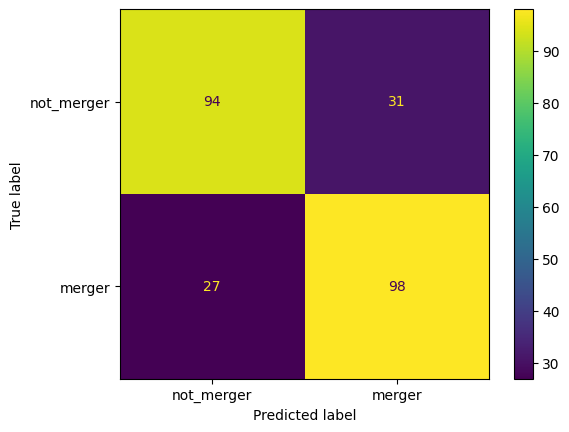

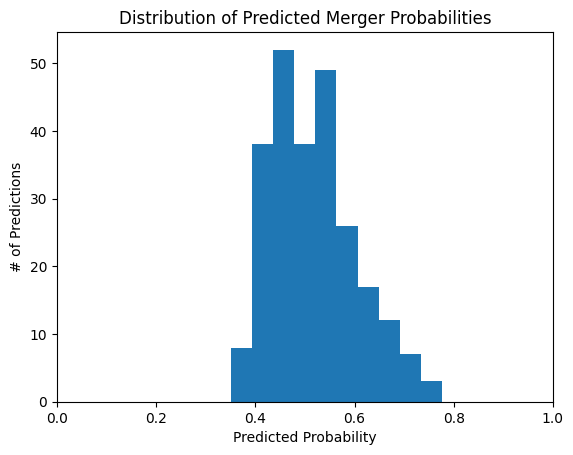

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

print('Accuracy:', np.mean(np.around(predictions['merger_pred']) == predictions['merger']))
print(predictions['merger_pred'])
cm = confusion_matrix(predictions['merger'],np.around(predictions['merger_pred']))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not_merger', 'merger'])
disp.plot()
plt.show()

# sns.kdeplot(predictions['merger_pred'])
# plt.xlim(0, 1)
# plt.show()

plt.hist(predictions['merger_pred'])
plt.xlim(0,1)
plt.ylabel("# of Predictions")
plt.xlabel("Predicted Probability")
plt.title("Distribution of Predicted Merger Probabilities")
plt.show()

In [82]:
def show_rings(df):
  # little utility function to visualise galaxies and our ring labels/predictions

  fig, axes = plt.subplots(ncols=5, figsize=(16, 3))
  for n in range(5):
    galaxy = df.iloc[n]

    im = Image.open(galaxy['file_loc'])
    axes[n].imshow(im)

    correct = np.around(galaxy['merger_pred']) == galaxy['merger']
    if correct:
      color = 'g'
    else:
      color = 'r'
    axes[n].text(20, 50, 'Pred: {:.2f}'.format(galaxy['merger_pred']), color=color)
    axes[n].text(20, 90, 'Label: {}'.format(galaxy['merger']), color=color)

    axes[n].axis('off')

65     GDS_22325.jpg
66      GDS_9284.jpg
95     GDS_22291.jpg
105       UDS_57.jpg
43     GDS_17495.jpg
           ...      
243    GDS_22374.jpg
182    COS_20054.jpg
203     UDS_3902.jpg
160    UDS_24028.jpg
220     COS_9597.jpg
Name: id_str, Length: 250, dtype: object


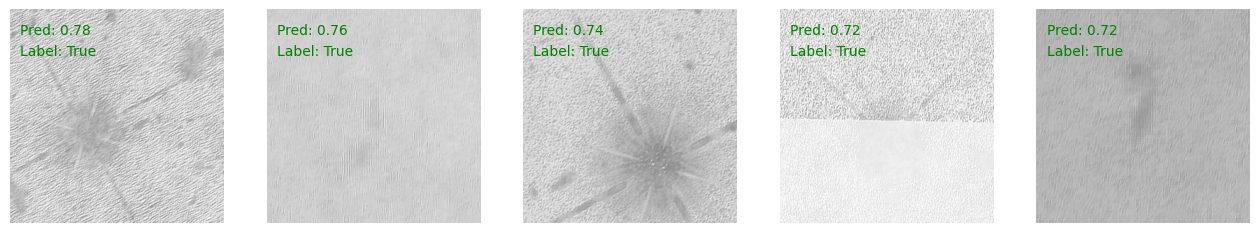

In [83]:
top_5_predictions = predictions.sort_values('merger_pred', ascending=False)
show_rings(top_5_predictions)
print(top_5_predictions['id_str'])

In [84]:
galrow = test_catalog.loc[test_catalog['filename'] == 'GDS_22130.jpg']
display(galrow)
print(galrow.to_string())
# print(test_catalog.loc[2422])
# plt.imshow(Image.open(galrow['file_loc']))

,smooth-or-featured-candels_smooth,smooth-or-featured-candels_features,smooth-or-featured-candels_artifact,how-rounded-candels_completely,how-rounded-candels_in-between,how-rounded-candels_cigar-shaped,clumpy-appearance-candels_yes,clumpy-appearance-candels_no,clump-count-candels_1,clump-count-candels_2,...,merging-candels_tidal-debris,merging-candels_both,merging-candels_neither,filename,ra,dec,file_loc,merger_frac,merger,id_str
55,34.0,24.0,17.0,14.0,20.0,0.0,21.0,3.0,0.0,8.0,...,1.0,7.0,10.0,GDS_22130.jpg,53.10871,-27.700054,/content/gz_candels/images_transformed/GDS_221...,0.810345,True,GDS_22130.jpg


    smooth-or-featured-candels_smooth  smooth-or-featured-candels_features  smooth-or-featured-candels_artifact  how-rounded-candels_completely  how-rounded-candels_in-between  how-rounded-candels_cigar-shaped  clumpy-appearance-candels_yes  clumpy-appearance-candels_no  clump-count-candels_1  clump-count-candels_2  clump-count-candels_3  clump-count-candels_4  clump-count-candels_5-plus  clump-count-candels_cant-tell  disk-edge-on-candels_yes  disk-edge-on-candels_no  edge-on-bulge-candels_yes  edge-on-bulge-candels_no  bar-candels_yes  bar-candels_no  has-spiral-arms-candels_yes  has-spiral-arms-candels_no  spiral-winding-candels_tight  spiral-winding-candels_medium  spiral-winding-candels_loose  spiral-arm-count-candels_1  spiral-arm-count-candels_2  spiral-arm-count-candels_3  spiral-arm-count-candels_4  spiral-arm-count-candels_5-plus  spiral-arm-count-candels_cant-tell  bulge-size-candels_none  bulge-size-candels_obvious  bulge-size-candels_dominant  merging-candels_merger  mergi

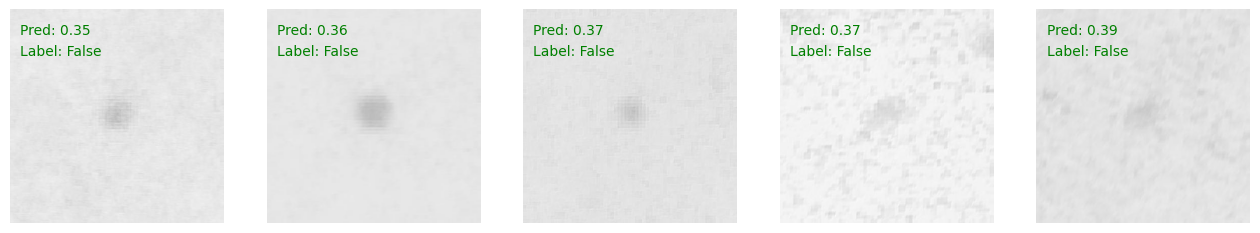

In [85]:
bottom_5_predictions = predictions.sort_values('merger_pred', ascending=True)
show_rings(bottom_5_predictions)

159    COS_17689.jpg
143    COS_10180.jpg
140    COS_14012.jpg
198     UDS_1676.jpg
141    GDS_14126.jpg
Name: id_str, dtype: object


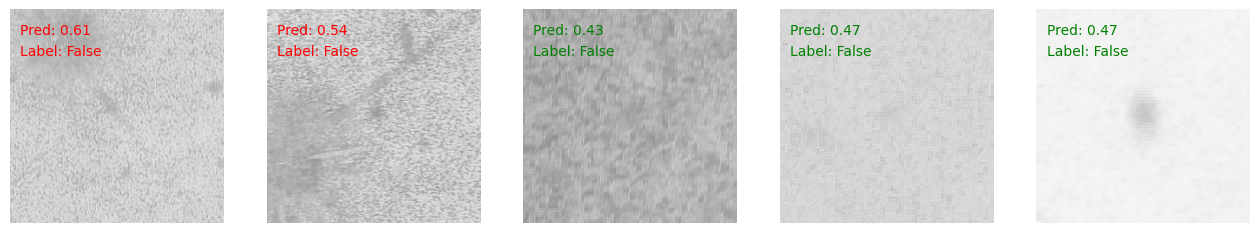

In [86]:
random_predictions = predictions.sample(5)
print(random_predictions['id_str'])
show_rings(random_predictions)

## Saving predictions to HDF5

By the way - you can also save predictions to hdf5. This is useful for saving higher-dimensional outputs (e.g. representations or multiple forward passes).

In [28]:
from zoobot.pytorch.predictions import predict_on_catalog

predict_on_catalog.predict(
  test_catalog,
  finetuned_model,
  n_samples=5,  # 5 forward passes with MC Dropout and different random augs
  label_cols=['not_ring', 'ring'],
  save_loc=os.path.join(save_dir, 'finetuned_predictions.hdf5'),
  trainer_kwargs={'accelerator': 'gpu'},
  datamodule_kwargs={'num_workers': 2, 'batch_size': 32, 'greyscale': False},
)

import h5py

with h5py.File(os.path.join(save_dir, 'finetuned_predictions.hdf5')) as f:
  print(f.keys())
  print(f['predictions'].shape)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

<KeysViewHDF5 ['id_str', 'label_cols', 'predictions']>
(250, 2, 5)


In [96]:
!zip -r /content/gz_candels/images_transformed.zip /content/gz_candels/images_transformed

  adding: content/gz_candels/images_transformed/ (stored 0%)
  adding: content/gz_candels/images_transformed/COS_13891.jpg (deflated 2%)
  adding: content/gz_candels/images_transformed/GDS_31653.jpg (deflated 6%)
  adding: content/gz_candels/images_transformed/GDS_16752.jpg (deflated 3%)
  adding: content/gz_candels/images_transformed/GDS_2302.jpg (deflated 2%)
  adding: content/gz_candels/images_transformed/COS_11445.jpg (deflated 3%)
  adding: content/gz_candels/images_transformed/GDS_1000.jpg (deflated 7%)
  adding: content/gz_candels/images_transformed/UDS_13182.jpg (deflated 2%)
  adding: content/gz_candels/images_transformed/COS_17964.jpg (deflated 5%)
  adding: content/gz_candels/images_transformed/GDS_7754.jpg (deflated 8%)
  adding: content/gz_candels/images_transformed/UDS_22058.jpg (deflated 2%)
  adding: content/gz_candels/images_transformed/UDS_26353.jpg (deflated 4%)
  adding: content/gz_candels/images_transformed/GDS_12883.jpg (deflated 11%)
  adding: content/gz_candels/

In [98]:
from google.colab import files
files.download("/content/gz_candels/images_transformed.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>